In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
file = pd.read_csv("heart.csv")
file.head()
file.values

array([[63.,  1.,  3., ...,  0.,  1.,  1.],
       [37.,  1.,  2., ...,  0.,  2.,  1.],
       [41.,  0.,  1., ...,  0.,  2.,  1.],
       ...,
       [68.,  1.,  0., ...,  2.,  3.,  0.],
       [57.,  1.,  0., ...,  1.,  3.,  0.],
       [57.,  0.,  1., ...,  1.,  2.,  0.]])

In [7]:
X = np.array(file.values[:,:-1])
X = StandardScaler().fit_transform(X)
y = np.array(file.values[:,-1]).reshape(-1,1).astype(int)

In [8]:
x_neg=X[165:303]
x_pos=X[0:165]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(138, 13)
(165, 13)


In [9]:
indices=np.arange(69)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:69]
x_train=np.concatenate((np.array(x_neg[0:69])[indices],x_pos)).reshape(-1,13)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[69:138].reshape(-1,13)
y_test = y_neg[69:138].reshape(-1,1)

# Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [14]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [16]:
num_of_iterations = 5#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(165, 13)
Size: 10 Bits - FPR: 0.869565 - Time Taken to create Standard: 0.002132 - Time Taken to create Projecion: 0.131730 



Size: 20 Bits - FPR: 0.782609 - Time Taken to create Standard: 0.001657 - Time Taken to create Projecion: 0.161667 



Size: 30 Bits - FPR: 0.739130 - Time Taken to create Standard: 0.002387 - Time Taken to create Projecion: 0.108760 



Size: 40 Bits - FPR: 0.840580 - Time Taken to create Standard: 0.001763 - Time Taken to create Projecion: 0.168909 



Size: 50 Bits - FPR: 0.739130 - Time Taken to create Standard: 0.001823 - Time Taken to create Projecion: 0.124366 



Size: 60 Bits - FPR: 0.695652 - Time Taken to create Standard: 0.001072 - Time Taken to create Projecion: 0.120401 



Size: 70 Bits - FPR: 0.536232 - Time Taken to create Standard: 0.001743 - Time Taken to create Projecion: 0.265918 



Size: 80 Bits - FPR: 0.608696 - Time Taken to create Standard: 0.005484 - Time Taken to create Projecion: 0.460116 



Size: 

Size: 700 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001112 - Time Taken to create Projecion: 0.146777 



Size: 710 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.001093 - Time Taken to create Projecion: 0.082644 



Size: 720 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.004980 - Time Taken to create Projecion: 0.107592 



Size: 730 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001404 - Time Taken to create Projecion: 0.133160 



Size: 740 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.002826 - Time Taken to create Projecion: 0.131370 



Size: 750 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001961 - Time Taken to create Projecion: 0.154789 



Size: 760 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.005090 - Time Taken to create Projecion: 0.539563 



Size: 770 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.003892 - Time Taken to create Projecion: 0.489273 



Size: 780 Bits - FPR: 0.130435 - Time Ta

Size: 1380 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.002684 - Time Taken to create Projecion: 0.185851 



Size: 1390 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002662 - Time Taken to create Projecion: 0.207537 



Size: 1400 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.005641 - Time Taken to create Projecion: 0.169328 



Size: 1410 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.002333 - Time Taken to create Projecion: 0.217725 



Size: 1420 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.002824 - Time Taken to create Projecion: 0.156567 



Size: 1430 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002207 - Time Taken to create Projecion: 0.158278 



Size: 1440 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.008064 - Time Taken to create Projecion: 0.141692 



Size: 1450 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.004010 - Time Taken to create Projecion: 0.244312 



Size: 1460 Bits - FPR: 0.043478 

Size: 2060 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.014144 - Time Taken to create Projecion: 0.556087 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.057753 - Time Taken to create Projecion: 0.518162 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.008940 - Time Taken to create Projecion: 0.414640 



Size: 2090 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.027768 - Time Taken to create Projecion: 0.326348 



Size: 2100 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.006706 - Time Taken to create Projecion: 0.294190 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005708 - Time Taken to create Projecion: 0.396092 



Size: 2120 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.004450 - Time Taken to create Projecion: 0.465592 



Size: 2130 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.009770 - Time Taken to create Projecion: 0.409812 



Size: 2140 Bits - FPR: 0.014493 

Size: 2740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.020757 - Time Taken to create Projecion: 0.576548 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004201 - Time Taken to create Projecion: 0.386461 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.014949 - Time Taken to create Projecion: 0.977457 



Size: 2770 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.008765 - Time Taken to create Projecion: 1.421246 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009139 - Time Taken to create Projecion: 1.598753 



Size: 2790 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.013092 - Time Taken to create Projecion: 1.264705 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009777 - Time Taken to create Projecion: 0.720776 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.037872 - Time Taken to create Projecion: 0.778922 



Size: 2820 Bits - FPR: 0.000000 

Size: 430 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.001175 - Time Taken to create Projecion: 0.128104 



Size: 440 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.001229 - Time Taken to create Projecion: 0.087041 



Size: 450 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.000819 - Time Taken to create Projecion: 0.080513 



Size: 460 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.001338 - Time Taken to create Projecion: 0.095360 



Size: 470 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000824 - Time Taken to create Projecion: 0.141809 



Size: 480 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001747 - Time Taken to create Projecion: 0.274287 



Size: 490 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.004125 - Time Taken to create Projecion: 0.102999 



Size: 500 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.001092 - Time Taken to create Projecion: 0.149182 



Size: 510 Bits - FPR: 0.202899 - Time Ta

Size: 1120 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.003763 - Time Taken to create Projecion: 0.517051 



Size: 1130 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.013995 - Time Taken to create Projecion: 0.574405 



Size: 1140 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.008295 - Time Taken to create Projecion: 0.380911 



Size: 1150 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.002486 - Time Taken to create Projecion: 0.941212 



Size: 1160 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.004987 - Time Taken to create Projecion: 0.769516 



Size: 1170 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.003409 - Time Taken to create Projecion: 0.168041 



Size: 1180 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.003939 - Time Taken to create Projecion: 0.144905 



Size: 1190 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.003237 - Time Taken to create Projecion: 0.718203 



Size: 1200 Bits - FPR: 0.057971 

Size: 1810 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002514 - Time Taken to create Projecion: 0.185000 



Size: 1820 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002905 - Time Taken to create Projecion: 0.162899 



Size: 1830 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003710 - Time Taken to create Projecion: 0.168937 



Size: 1840 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002629 - Time Taken to create Projecion: 0.165891 



Size: 1850 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.003330 - Time Taken to create Projecion: 0.202682 



Size: 1860 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.005815 - Time Taken to create Projecion: 0.168272 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002851 - Time Taken to create Projecion: 0.483006 



Size: 1880 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.023709 - Time Taken to create Projecion: 0.786403 



Size: 1890 Bits - FPR: 0.000000 

Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004060 - Time Taken to create Projecion: 0.297685 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004220 - Time Taken to create Projecion: 0.901120 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.018378 - Time Taken to create Projecion: 0.917934 



Size: 2520 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.027967 - Time Taken to create Projecion: 0.504913 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.017850 - Time Taken to create Projecion: 0.263283 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004705 - Time Taken to create Projecion: 1.179403 



Size: 2550 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.015049 - Time Taken to create Projecion: 1.255431 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.016275 - Time Taken to create Projecion: 1.016758 



Size: 2570 Bits - FPR: 0.000000 

Size: 170 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.002367 - Time Taken to create Projecion: 0.499799 



Size: 180 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.004692 - Time Taken to create Projecion: 0.201254 



Size: 190 Bits - FPR: 0.376812 - Time Taken to create Standard: 0.002349 - Time Taken to create Projecion: 0.341073 



Size: 200 Bits - FPR: 0.463768 - Time Taken to create Standard: 0.001225 - Time Taken to create Projecion: 0.134263 



Size: 210 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.001660 - Time Taken to create Projecion: 0.417444 



Size: 220 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.003078 - Time Taken to create Projecion: 0.420710 



Size: 230 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.001906 - Time Taken to create Projecion: 0.166968 



Size: 240 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.001247 - Time Taken to create Projecion: 0.144282 



Size: 250 Bits - FPR: 0.550725 - Time Ta

Size: 860 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.008182 - Time Taken to create Projecion: 0.321201 



Size: 870 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.010534 - Time Taken to create Projecion: 0.290524 



Size: 880 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.007933 - Time Taken to create Projecion: 0.189350 



Size: 890 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.002445 - Time Taken to create Projecion: 0.217994 



Size: 900 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001444 - Time Taken to create Projecion: 0.236856 



Size: 910 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.003145 - Time Taken to create Projecion: 0.211875 



Size: 920 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.005720 - Time Taken to create Projecion: 0.161370 



Size: 930 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003736 - Time Taken to create Projecion: 0.168943 



Size: 940 Bits - FPR: 0.028986 - Time Ta

Size: 1540 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.015677 - Time Taken to create Projecion: 0.281570 



Size: 1550 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.002754 - Time Taken to create Projecion: 0.243219 



Size: 1560 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.003746 - Time Taken to create Projecion: 0.325326 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003465 - Time Taken to create Projecion: 0.293862 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003518 - Time Taken to create Projecion: 0.223572 



Size: 1590 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002821 - Time Taken to create Projecion: 0.226431 



Size: 1600 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003838 - Time Taken to create Projecion: 0.296834 



Size: 1610 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.006365 - Time Taken to create Projecion: 0.444959 



Size: 1620 Bits - FPR: 0.000000 

Size: 2220 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.015510 - Time Taken to create Projecion: 0.452274 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004641 - Time Taken to create Projecion: 0.283152 



Size: 2240 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.005077 - Time Taken to create Projecion: 0.318347 



Size: 2250 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.005282 - Time Taken to create Projecion: 0.327152 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006509 - Time Taken to create Projecion: 0.403838 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009638 - Time Taken to create Projecion: 0.576458 



Size: 2280 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.007338 - Time Taken to create Projecion: 0.635081 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005893 - Time Taken to create Projecion: 0.808244 



Size: 2300 Bits - FPR: 0.000000 

Size: 2900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.008543 - Time Taken to create Projecion: 0.291278 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.007054 - Time Taken to create Projecion: 0.273415 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006831 - Time Taken to create Projecion: 0.292864 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005555 - Time Taken to create Projecion: 0.229951 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004437 - Time Taken to create Projecion: 0.226713 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.018627 - Time Taken to create Projecion: 0.251667 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005915 - Time Taken to create Projecion: 0.255698 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005259 - Time Taken to create Projecion: 0.226025 



Size: 2980 Bits - FPR: 0.000000 

Size: 590 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.002736 - Time Taken to create Projecion: 0.111628 



Size: 600 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.002427 - Time Taken to create Projecion: 0.389337 



Size: 610 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.002621 - Time Taken to create Projecion: 0.099217 



Size: 620 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.003422 - Time Taken to create Projecion: 0.164581 



Size: 630 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.007218 - Time Taken to create Projecion: 0.105644 



Size: 640 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.002284 - Time Taken to create Projecion: 0.091777 



Size: 650 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.001538 - Time Taken to create Projecion: 0.218702 



Size: 660 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.002102 - Time Taken to create Projecion: 0.147768 



Size: 670 Bits - FPR: 0.304348 - Time Ta

Size: 1290 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001988 - Time Taken to create Projecion: 0.199097 



Size: 1300 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002238 - Time Taken to create Projecion: 0.138937 



Size: 1310 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003416 - Time Taken to create Projecion: 0.194624 



Size: 1320 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002399 - Time Taken to create Projecion: 0.159995 



Size: 1330 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.003758 - Time Taken to create Projecion: 0.134484 



Size: 1340 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.003969 - Time Taken to create Projecion: 0.149518 



Size: 1350 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002076 - Time Taken to create Projecion: 0.185215 



Size: 1360 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.009120 - Time Taken to create Projecion: 0.162454 



Size: 1370 Bits - FPR: 0.043478 

Size: 1970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005777 - Time Taken to create Projecion: 0.229670 



Size: 1980 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003248 - Time Taken to create Projecion: 0.182316 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004070 - Time Taken to create Projecion: 0.174516 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004024 - Time Taken to create Projecion: 0.254094 



Size: 2010 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003096 - Time Taken to create Projecion: 0.183965 



Size: 2020 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003496 - Time Taken to create Projecion: 0.562224 



Size: 2030 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.053692 - Time Taken to create Projecion: 0.394220 



Size: 2040 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.066527 - Time Taken to create Projecion: 0.691650 



Size: 2050 Bits - FPR: 0.014493 

Size: 2650 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004227 - Time Taken to create Projecion: 0.442186 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006647 - Time Taken to create Projecion: 0.398842 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009105 - Time Taken to create Projecion: 0.524467 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003848 - Time Taken to create Projecion: 0.241566 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006991 - Time Taken to create Projecion: 0.233792 



Size: 2700 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.005002 - Time Taken to create Projecion: 0.378829 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006690 - Time Taken to create Projecion: 0.386233 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.029792 - Time Taken to create Projecion: 0.502884 



Size: 2730 Bits - FPR: 0.000000 

Size: 330 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.003024 - Time Taken to create Projecion: 0.370473 



Size: 340 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.002265 - Time Taken to create Projecion: 0.188162 



Size: 350 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.001690 - Time Taken to create Projecion: 0.203710 



Size: 360 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.003066 - Time Taken to create Projecion: 0.507143 



Size: 370 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.003409 - Time Taken to create Projecion: 0.361970 



Size: 380 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.001345 - Time Taken to create Projecion: 0.344942 



Size: 390 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.001957 - Time Taken to create Projecion: 0.225510 



Size: 400 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.001254 - Time Taken to create Projecion: 0.150467 



Size: 410 Bits - FPR: 0.188406 - Time Ta

Size: 1020 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.002658 - Time Taken to create Projecion: 0.267570 



Size: 1030 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001659 - Time Taken to create Projecion: 0.148085 



Size: 1040 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.003794 - Time Taken to create Projecion: 0.309783 



Size: 1050 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.008685 - Time Taken to create Projecion: 0.397255 



Size: 1060 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002867 - Time Taken to create Projecion: 0.290297 



Size: 1070 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.002141 - Time Taken to create Projecion: 0.288633 



Size: 1080 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.004206 - Time Taken to create Projecion: 0.419148 



Size: 1090 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.003333 - Time Taken to create Projecion: 0.430446 



Size: 1100 Bits - FPR: 0.101449 


Size: 1710 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.002421 - Time Taken to create Projecion: 0.334760 



Size: 1720 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.003249 - Time Taken to create Projecion: 0.227633 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003408 - Time Taken to create Projecion: 0.184853 



Size: 1740 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.002515 - Time Taken to create Projecion: 0.221897 



Size: 1750 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.005326 - Time Taken to create Projecion: 0.267506 



Size: 1760 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003379 - Time Taken to create Projecion: 0.178732 



Size: 1770 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.005699 - Time Taken to create Projecion: 0.187538 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004362 - Time Taken to create Projecion: 0.201935 



Size: 1790 Bits - FPR: 0.000000

Size: 2390 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004523 - Time Taken to create Projecion: 0.220822 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004661 - Time Taken to create Projecion: 0.218736 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004800 - Time Taken to create Projecion: 0.347788 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006613 - Time Taken to create Projecion: 0.232691 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004610 - Time Taken to create Projecion: 0.221369 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003593 - Time Taken to create Projecion: 0.221911 



Size: 2450 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.007385 - Time Taken to create Projecion: 0.249551 



Size: 2460 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003742 - Time Taken to create Projecion: 0.233798 



Size: 2470 Bits - FPR: 0.014493 

In [17]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [18]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


In [19]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [20]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [21]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

1500
[165]


# FPR Comparison between Projection Model and Normal Bloom Filter

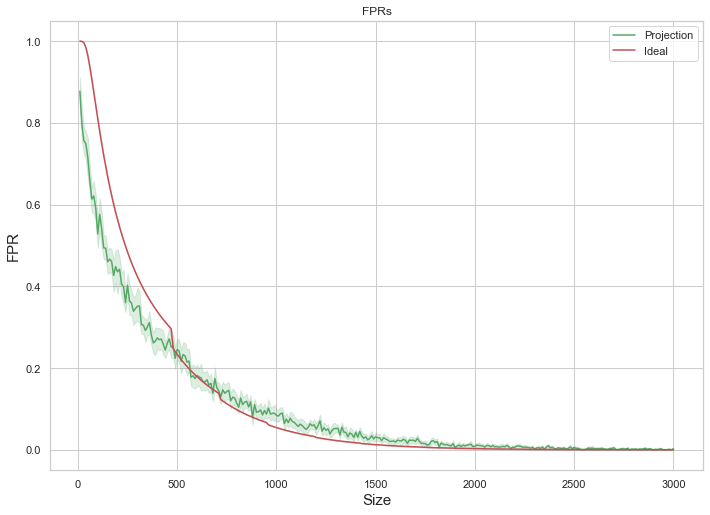

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [22]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [23]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [24]:
print(average_fprs)

[0.8775362318840578, 0.7971014492753624, 0.7565217391304347, 0.7492753623188405, 0.7152173913043478, 0.660144927536232, 0.613768115942029, 0.6210144927536232, 0.5913043478260869, 0.5282608695652173, 0.5760869565217391, 0.5391304347826087, 0.4942028985507247, 0.49347826086956514, 0.4601449275362318, 0.4666666666666666, 0.4608695652173913, 0.42681159420289855, 0.44855072463768125, 0.4355072463768116, 0.4420289855072463, 0.4057971014492754, 0.39927536231884064, 0.36014492753623195, 0.4028985507246377, 0.36449275362318845, 0.35942028985507246, 0.3391304347826086, 0.3456521739130435, 0.35144927536231885, 0.35217391304347834, 0.3065217391304348, 0.305072463768116, 0.2920289855072464, 0.30072463768115937, 0.31159420289855067, 0.2811594202898551, 0.26159420289855073, 0.26594202898550723, 0.2739130434782609, 0.2695652173913043, 0.2710144927536232, 0.2586956521739131, 0.24420289855072466, 0.26014492753623186, 0.27173913043478265, 0.25144927536231887, 0.2536231884057972, 0.22391304347826094, 0.24

In [22]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.002132,0.002201,0.869565,0.866667,0.131730,0.220209
1,20,0.999789,0.001657,0.004695,0.782609,0.788406,0.161667,0.309063
2,30,0.996279,0.002387,0.001913,0.739130,0.826087,0.108760,0.236610
3,40,0.984662,0.001763,0.001534,0.840580,0.742029,0.168909,0.260502
4,50,0.964330,0.001823,0.002392,0.739130,0.715942,0.124366,0.215640


In [24]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/heart_rerun_epochs_100.csv')